In [3]:
import sys
sys.path.append('../..')
sys.path.append('../../..')
sys.path.append('..')

from selective_recruitment.plotting import make_scatterplot
from selective_recruitment.scripts.script_mapwise import calc_ttest_mean
from selective_recruitment.scripts.script_roi_differences import norm_within_category # for results after normalization

import selective_recruitment.regress as ra
import selective_recruitment.region as sroi

from statsmodels.stats.anova import AnovaRM  # perform F test
from scipy.stats import ttest_rel

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [7]:
# setting working directory
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'

# selective recruitment: ROI-based
scatterplots and statistical tests on the residuals for the selected region of interest

In [8]:
# setting up names and colors
label_dict = {1: 'Enc2F', 2: 'Ret2F',
              3: 'Enc2B', 4: 'Ret2B',
              5: 'Enc4F', 6: 'Ret4F',
              7: 'Enc4B', 8: 'Ret4B',
              9: 'Enc6F', 10: 'Ret6F',
              11: 'Enc6B', 12: 'Ret6B',
              13: 'rest'}
marker_dict = {1: 'o', 2: 'X',
               3: 'o', 4: 'X',
               5: 'o', 6: 'X',
               7: 'o', 8: 'X',
               9: 'o', 10: 'X',
               11: 'o', 12: 'X',
               13: 's'}
color_dict = {1: 'b', 2: 'b',
              3: 'r', 4: 'r',
              5: 'b', 6: 'b',
              7: 'r', 8: 'r',
              9: 'b', 10: 'b',
              11: 'r', 12: 'r',
              13: 'g'}

## Prepare the data for the scatterplot and the test

* Pick one parcellation: Here NettekovenSym32, a data-driven hierarchical symmetric parcellation. ROI will be selected from this parcellation.
* ss.get_summary_conn first uses a connectivity model to get predicted values for all the cerebellar voxels and then summarize the predicted values by averaging the values within the selected region of interest.


In [4]:
# get the summary df with observed and predicted activation within cerebellar parcels

## set params
dataset = "WMFS"
ses_id = 'ses-02'
parcellation = "NettekovenSym32"
cortex = "Icosahedron1002"
type = "CondHalf"
crossed = True
# mname_base = f'MDTB_all_{cortex}_L2regression'
# mname_ext = "_A8" # if you want to use the fused model, mname_ext will be fuse_id. Use "_A8" for the non-fused model
mname_base = f'Fusion_all_{cortex}_L2regression'
mname_ext = "_09" # if you want to use the fused model, mname_ext will be fuse_id. Use "_A8" for the non-fused model
# get predicted and observed within region of interest
# D = ss.get_summary_conn(dataset = dataset,
#                      ses_id = ses_id,
#                      subj = None, # to do all the subjects
#                      atlas_space = "SUIT3",
#                      cerebellum_roi = parcellation,
#                      cerebellum_roi_selected = None,
#                      cortex_roi = cortex,
#                      type = type,
#                      add_rest = True,
#                      mname_base = mname_base, # Fusion_all_Icosahedron1002_L2Regression_05_avg
#                      mname_ext = mname_ext,
#                      crossed = crossed)

# # apply regression to get residuals
# # this second regression is implemented because direct comparison of observed and
# # predicted activation is not possible due to different scaling
# D = ra.roi_regress(D, fit_intercept=True)

# # save the df
# D.to_csv(wkdir + f'/wm_ROI_{parcellation}_{cortex}_{type}_{mname_base}_{mname_ext}_conn_reg.tsv', sep='\t')
D = pd.read_csv(wkdir + f'/wm_ROI_{parcellation}_{cortex}_{type}_{mname_base}_{mname_ext}_conn_reg.tsv', sep='\t')

### Select region of interest.
Here we pick one parcel by first focusing on one network, the most relevant network: here the motor network. From the sub-regions within that network, we pick the one that shows consistently high activation throughout the task

In [5]:
roi_exp = "D.." # roi_exp = "D.?3.?R|D.?3.?L" # roi_exp = "D.?3.?R"
_, _, selected_ = sroi.get_parcel_single(parcellation = parcellation,
                                               atlas_space = "SUIT3",
                                               roi_exp = roi_exp)
print(selected_)
table = pd.pivot_table(D.loc[np.isin(D.roi_name.values, selected_)], values='Y', index=['roi_name'], aggfunc=np.mean)
sorted_regions = table.sort_values(by=["Y"],ascending=False)
display(sorted_regions.T)
roi_selected = sorted_regions.T.columns[0]
print(f"selected region is {roi_selected}")


['D1L', 'D2L', 'D3L', 'D4L', 'D1R', 'D2R', 'D3R', 'D4R']


roi_name,D3R,D1R,D3L,D4R,D1L,D4L,D2R,D2L
Y,0.147329,0.115368,0.107958,0.087033,0.073267,0.064869,0.053291,0.038532


selected region is D3R


### make the scatterplot and test the residuals

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  2.5493 11.0000 165.0000 0.0053



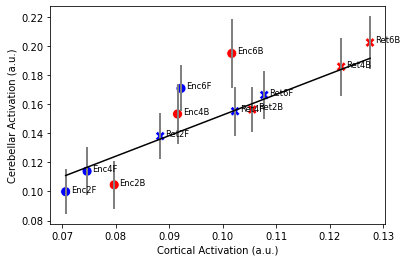

In [11]:
# wm_ROI_NettekovenSym32_Icosahedron1002_CondAll_Fusion_all_Icosahedron1002_L2regression__09_conn_reg
mname = 'NettekovenSym32_Icosahedron1002_CondHalf_Fusion_all_Icosahedron1002_L2regression__09'
D = pd.read_csv(wkdir + f'/wm_ROI_{mname}_conn_reg.tsv', sep='\t')


selected_roi = "D3R"
df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
make_scatterplot(df, split='cond_num',
                labels=label_dict,
                markers=marker_dict,
                colors=color_dict)
# plt.xlabel("predicted cerebellar activation")
# plt.savefig(f"wm_{selected_roi}_scatter_selected_model.pdf")
print(AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())

In [20]:
## Make table with statistical values
mname = ['NettekovenSym32_Icosahedron1002_CondHalf_Fusion_all_Icosahedron1002_L2regression__09',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_ses-s1_Icosahedron1002_L2regression__A8',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_ses-s1_Icosahedron1002_L1regression__A-5',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_all_Icosahedron1002_L2regression__A8',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_all_Icosahedron1002_L1regression__A-5']
selected_roi = "D3R"
for m in mname:
    D = pd.read_csv(wkdir + f'/wm_ROI_{m}_conn_reg.tsv', sep='\t')
    df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
    res = (AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())
    print(res.summary())